In [1]:
import numpy as np
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [2]:
import os
import sys
sys.path.append('..')

from alphazero import config
import stable_rad_config

In [4]:
config.experiment_id

'fixing_node_visits_1'

Text(0.5, 0, 'Time (hours)')

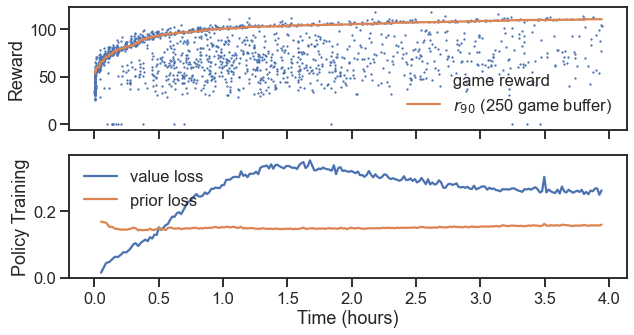

In [152]:
# Load the game buffer
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("select * from {}_game where experiment_id = %s".format(
        config.sql_basename), conn, params=(config.experiment_id,))
    
# Load the policy training history
log = pd.read_csv(os.path.join(config.checkpoint_filepath, 'log.csv'))
log['time'] = pd.to_datetime(log.time)

df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
log['time_hours'] = (log.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)

df = df.sort_values('time_hours')

fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(10, 5))

axs[0].plot(df.time_hours, df.real_reward, '.', ms=2.5, label='game reward')
axs[0].plot(df.time_hours, df.real_reward.rolling(250, min_periods=50).quantile(.9), label='$r_{90}$ (250 game buffer)')

axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

axs[1].legend()
axs[0].legend()

axs[0].set_ylabel('Reward')
axs[1].set_ylabel('Policy Training')
axs[1].set_xlabel('Time (hours)')

In [86]:
with psycopg2.connect(**config.dbparams) as conn:
    df = pd.read_sql_query("""
    with recent_replays as (
        select * from rl.{0}_replay where gameid in (
            select gameid from {0}_game where experiment_id = %s order by id desc limit %s))

    select distinct on (gameid) id, ranked_reward, data
        from recent_replays order by gameid, random();
    """.format(config.sql_basename), conn, params=(config.experiment_id, config.policy_buffer_max_size,))

from run_mcts import Game, StabilityNode

G = Game(StabilityNode, 'C')
iterator = G.run_mcts()

start0 = iterator.__next__()  # yields the starting node
start1 = iterator.__next__()  # runs the first mcts step
start2 = iterator.__next__()  # runs the second mcts step

INFO:alphazero.game:4dbb6430: loaded checkpoint /scratch/pstjohn/policy_checkpoints/StablePSJ/fixing_node_visits_1/policy.225
INFO:alphazero.game:4dbb6430: selecting node <C> with value=0.000 and visits=0
INFO:alphazero.game:4dbb6430: selecting node <CC> with value=0.203 and visits=113
INFO:alphazero.game:4dbb6430: selecting node <CCS> with value=0.262 and visits=124


In [122]:
import tensorflow as tf

visit_counts = np.array([child.visits for child in start1.successors])
value, prior_logits = G.policy_predictions(start1.policy_inputs_with_children())
policy_pred_visits = tf.nn.softmax(prior_logits[1:, 0])
actual_visit_probs = tf.constant(visit_counts / visit_counts.sum(), dtype=policy_pred_visits.dtype)

(tf.keras.losses.categorical_crossentropy(actual_visit_probs, prior_logits[1:, 0], from_logits=True) - 
 tf.keras.losses.categorical_crossentropy(actual_visit_probs, actual_visit_probs, from_logits=False))

<tf.Tensor: shape=(), dtype=float32, numpy=0.17384863>

Text(0.5, 1.0, 'Loss for random predictions')

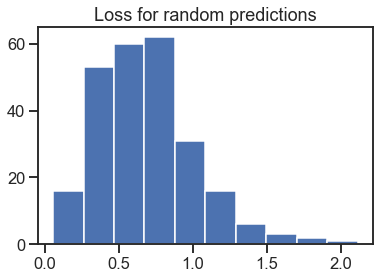

In [154]:
random_losses = np.array([
    (tf.keras.losses.categorical_crossentropy(actual_visit_probs, tf.random.normal(prior_logits[1:, 0].shape), from_logits=True) - 
     tf.keras.losses.categorical_crossentropy(actual_visit_probs, actual_visit_probs, from_logits=False)).numpy() for i in range(250)])

_ = plt.hist(random_losses)
plt.title('Loss for random predictions')

In [151]:
df.tail(20)

,id,ranked_reward,data
1004,78078,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1005,66687,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1006,76878,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1007,68112,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1008,69116,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1009,63744,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1010,67700,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1011,70191,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1012,66039,0.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."
1013,76280,1.0,"[b'P', b'K', b'\x03', b'\x04', b'\x14', b'\x00..."


In [82]:
# Load the reward buffer to plot the optimal molecules
with psycopg2.connect(**config.dbparams) as conn:
    rew_df = pd.read_sql_query("select * from {}_reward".format(config.sql_basename), conn)

rew_df.shape

(1887437, 7)

In [83]:
rew_df.sort_values('real_reward', ascending=False).head(10)

,smiles,time,real_reward,atom_type,buried_vol,max_spin,atom_index
810327,C=C(C(C)C)C(C([O])=O)(N(C)C)N(C)C,2020-10-22 11:32:51.080562,125.286545,C,84.191390,0.178097,5
705000,CCN(C)[C@@](OC)(C([O])=O)N(C)C(C)C,2020-10-22 10:54:22.618236,123.938200,C,83.308556,0.187407,4
1801973,CCCN(CCS)[C@](C)(C([O])=O)N(C)C,2020-11-22 13:29:17.977386,122.412590,N,79.207570,0.135900,3
750701,CN(O)C(=O)C(C([O])=O)(N(C)C)N(C)C,2020-10-22 11:09:10.883222,122.236010,C,79.746850,0.150217,5
878512,CC1=C[C@]1([O])N(C(C)C)C(C)(C)C,2020-10-22 12:06:42.490719,120.605890,N,78.927704,0.166436,5
704953,CCO[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 10:54:22.027057,120.559074,C,82.196130,0.232741,3
791380,CC(=O)[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 11:25:51.098359,120.482110,C,82.235310,0.235064,3
670580,C=C(O)[C@](C([O])=O)(N(C)C)N(C)CCC,2020-10-22 10:44:44.413717,120.424030,C,80.067890,0.192877,3
715837,C=C(C)[C@@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 10:57:56.041969,120.378260,C,83.819910,0.268833,3
752838,C=C(C)[C@](C([O])=O)(N(C)C)N(C)C(C)C,2020-10-22 11:10:34.069426,120.307510,C,83.008896,0.254028,3


In [64]:
stable_df = pd.read_csv('/home/pstjohn/Research/20200608_redox_calculations/stable_radicals/stable-with-H-sas-numatoms.csv', index_col=0)

In [68]:
stable_df['can_smiles'] = stable_df.smiles.apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [71]:
stable_df.can_smiles.isin(rew_df.smiles).any()

False

In [26]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    orig_costs = np.array(costs)
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return orig_costs[is_efficient_mask]
    else:
        return is_efficient

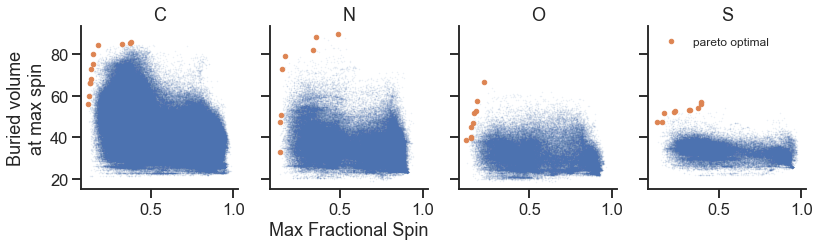

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(13, 3), sharex=True, sharey=True)

optimal = []
for ax, atom in zip(axs, ['C', 'N', 'O', 'S']):
    
    vals = rew_df[rew_df.atom_type == atom][['max_spin', 'buried_vol']].dropna()
    vals['buried_vol'] *= -1
    pareto_index = is_pareto_efficient(vals.values, return_mask=False)
    pareto_points = vals.iloc[pareto_index]
    optimal += [vals.iloc[pareto_index].index]
    
    ax.plot(rew_df[rew_df.atom_type == atom]['max_spin'],
            rew_df[rew_df.atom_type == atom]['buried_vol'], '.', ms=1, alpha=.1)
    
    ax.plot(pareto_points['max_spin'], -pareto_points['buried_vol'], '.', label='pareto optimal')
    
    ax.set_title(atom)

    
axs[1].set_xlabel('Max Fractional Spin')
axs[0].set_ylabel('Buried volume\nat max spin')

axs[-1].legend(loc='upper left', fontsize=12)
sns.despine()    

In [28]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from IPython.display import SVG

INFO:rdkit:Enabling RDKit 2020.03.4 jupyter extensions


In [30]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [42]:
from run_mcts import predict
from alphazero.node import Node

def pred_spins(mol):
    spins, _ = predict(
        {key: tf.constant(np.expand_dims(val, 0))
         for key, val in Node(mol).policy_inputs.items()})
    
    return spins.numpy().flatten()

In [35]:
# Code for raster image drawing
from rdkit.Chem.Draw import SimilarityMaps

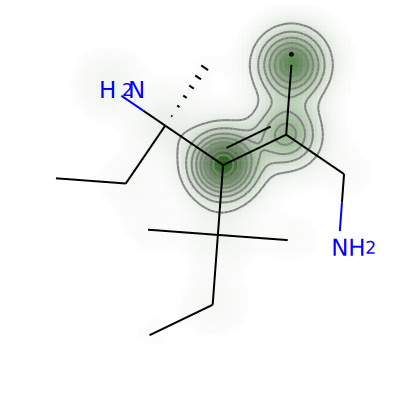

In [56]:
row = rew_df.reindex(pd.Series(optimal[0]).sample(5)).iloc[0]
mol = Chem.MolFromSmiles(row.smiles)

d = rdMolDraw2D.MolDraw2DSVG(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(mol, [float(i) for i in pred_spins(mol)], draw2d=d)
d.FinishDrawing()
SVG(d.GetDrawingText())

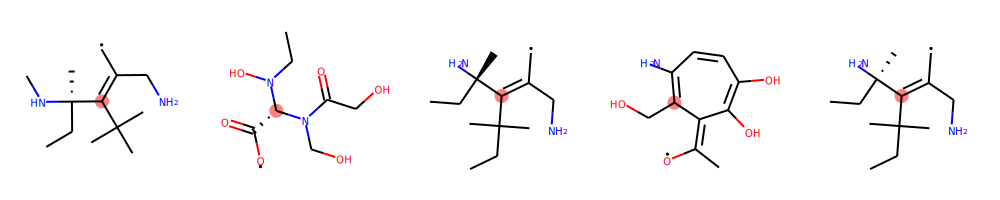

In [57]:
to_plot = rew_df.reindex(pd.Series(optimal[0]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

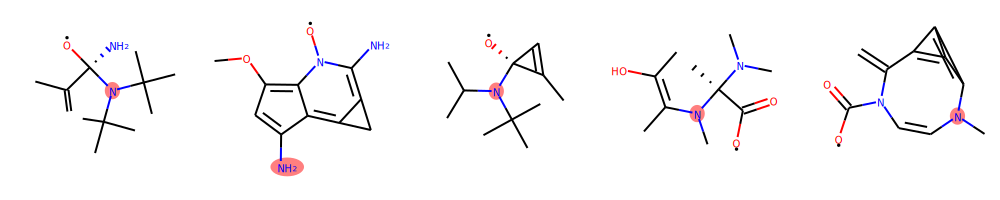

In [58]:
to_plot = rew_df.reindex(pd.Series(optimal[1]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

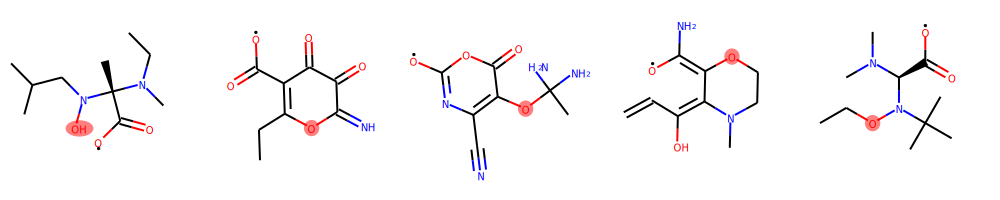

In [59]:
to_plot = rew_df.reindex(pd.Series(optimal[2]))[rew_df.reindex(pd.Series(optimal[2])).buried_vol > 45].sample(5)
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

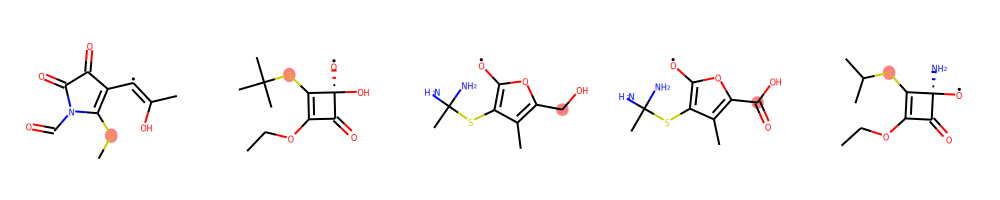

In [60]:
to_plot = rew_df.reindex(pd.Series(optimal[3]).sample(5))
d2d = rdMolDraw2D.MolDraw2DSVG(1000, 200, 200, 200)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

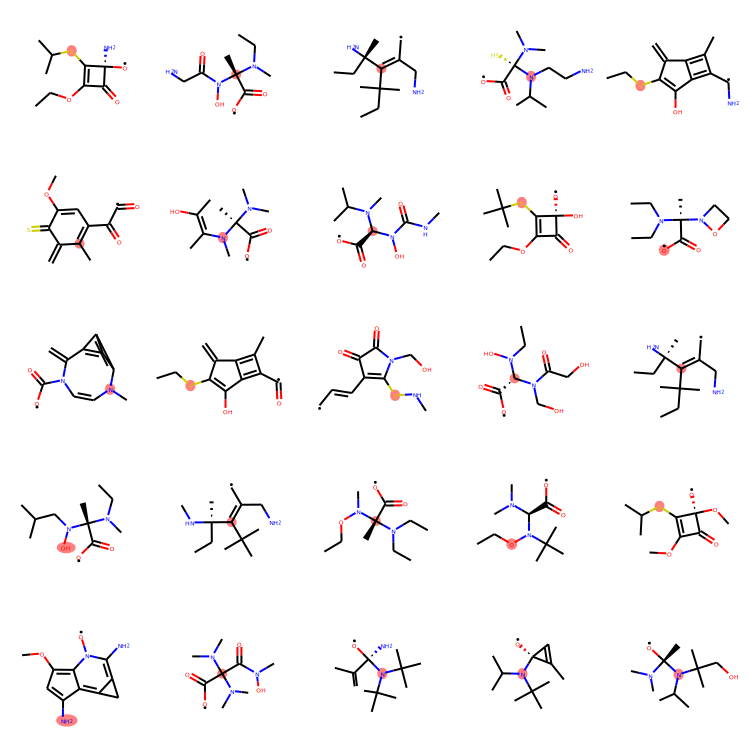

In [61]:
to_plot = rew_df.reindex(np.concatenate(optimal)).sample(25)
d2d = rdMolDraw2D.MolDraw2DSVG(150*5, 150*5, 150, 150)
opts = d2d.drawOptions()
d2d.DrawMolecules([Chem.MolFromSmiles(row.smiles) for _, row in to_plot.iterrows()],
                  highlightAtoms=[(int(row.atom_index),) for _, row in to_plot.iterrows()])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

looks like atom ordering isn't consistent

TODO: 
* Maybe do ranked reward on an atom-by-atom basis?
* http://rdkit.blogspot.com/2020/01/similarity-maps-with-new-drawing-code.html
* add large pieces at once? (benzyl ring, etc)